In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from branca.element import Figure
import folium


In [3]:
# Carregando os dados
df = pd.read_csv("../../project_files/03_processed_files/meds_train_alunos.csv")


In [4]:
X = df[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]
y = df[['num_lat_bts', 'num_long_bts']]

In [5]:
# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Treinamento do modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [7]:
# Previsões Linear regression
y_pred = model.predict(X_test)

In [8]:
df2 = y_test.copy()
df2['lat_pred'] = [lat for lat,_ in y_pred]
df2['lon_pred'] = [lon for _,lon in y_pred]

In [9]:
df2['lat_diff'] = df2['num_lat_bts'] - df2['lat_pred']
df2['lon_diff'] = df2['num_long_bts'] - df2['lon_pred']

In [10]:
df2.head()

,num_lat_bts,num_long_bts,lat_pred,lon_pred,lat_diff,lon_diff
5997,-8.048630,-34.952930,-8.049924,-34.952628,0.001294,-0.000302
4882,-8.055506,-34.951693,-8.056214,-34.952587,0.000708,0.000894
2955,-8.055786,-34.951505,-8.054974,-34.951361,-0.000812,-0.000144
2303,-8.047130,-34.950590,-8.049603,-34.952317,0.002473,0.001727
496,-8.051920,-34.947800,-8.052539,-34.946846,0.000619,-0.000954


In [11]:
df2['lat_diff_metros'] = df2['lat_diff'] * 30.87 * 1000
df2['lon_diff_metros'] = df2['lon_diff'] * 30.87 * 1000

In [12]:
df2['diff_metros'] = [math.sqrt(lat_diff**2+lon_diff**2) for lat_diff,lon_diff in zip(df2['lat_diff_metros'],df2['lon_diff_metros'])]

In [13]:
df2['diff_metros'].describe()

count    1353.000000
mean       49.866347
std        36.265885
min         2.285480
25%        30.056302
50%        40.565949
75%        60.186248
max       311.710359
Name: diff_metros, dtype: float64

<Axes: >

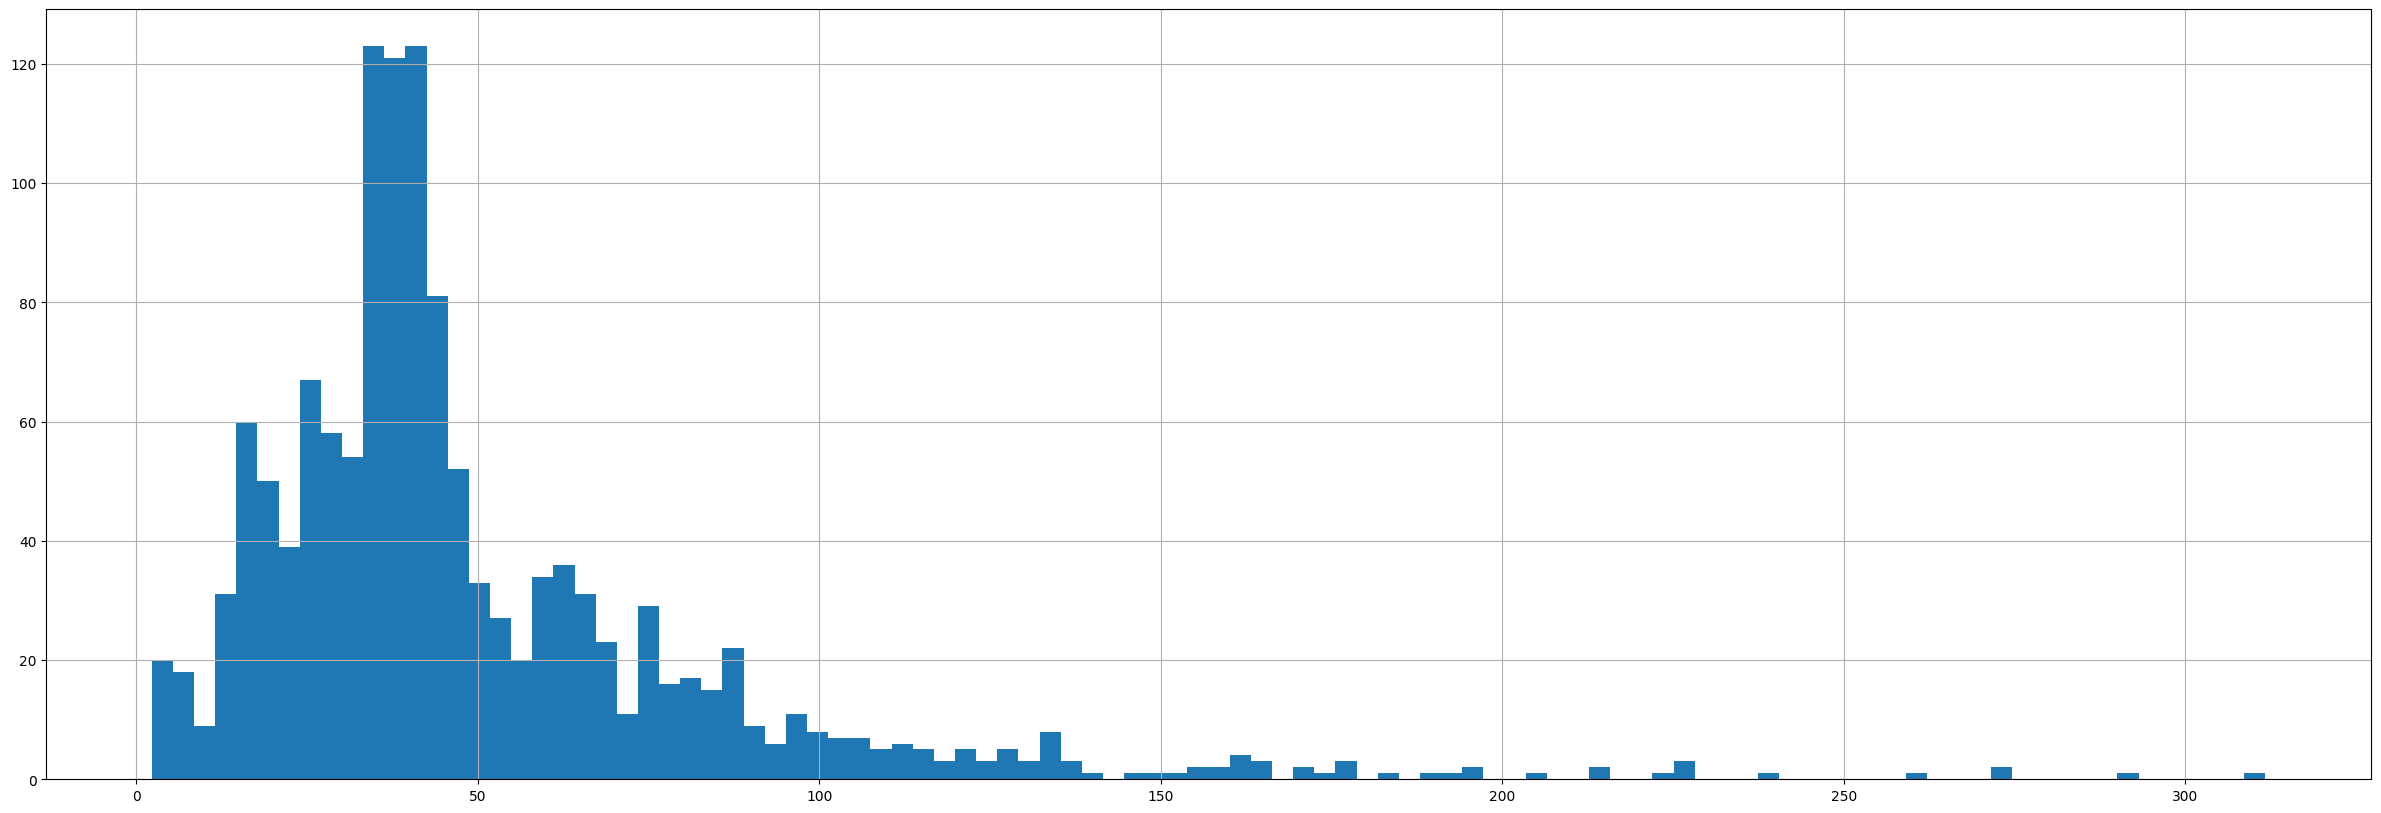

In [14]:
df2['diff_metros'].hist(bins=100,figsize=(30,10))


## MAPA DE COMPARACAO

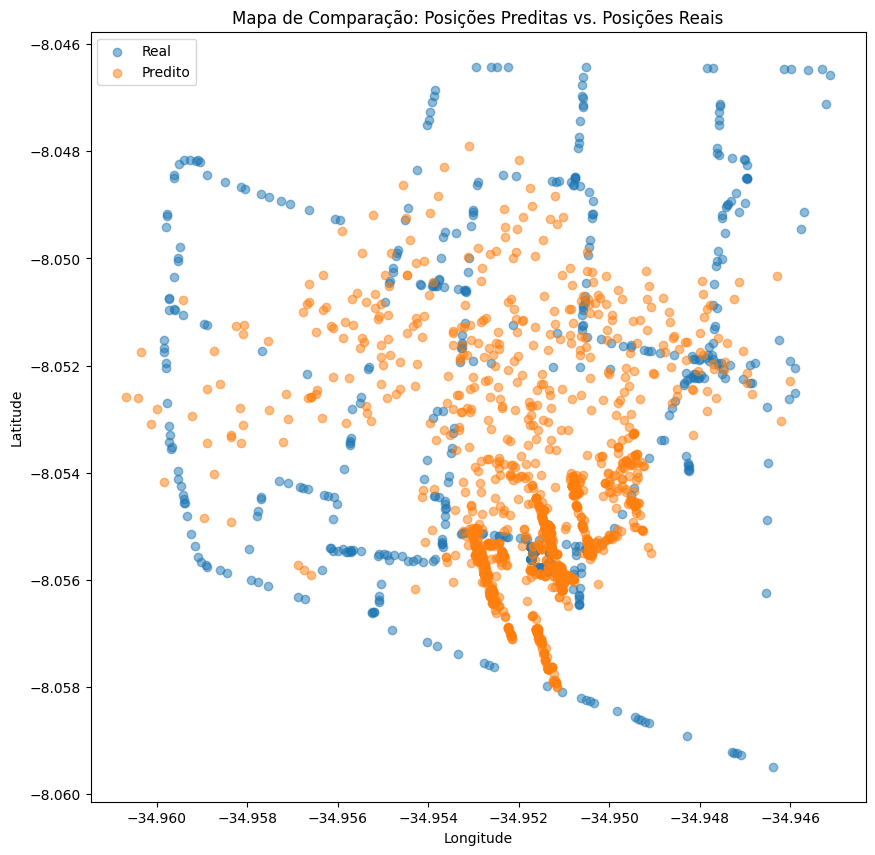

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test['num_long_bts'], y_test['num_lat_bts'], label='Real', alpha=0.5)
plt.scatter(y_pred[:, 1], y_pred[:, 0], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapa de Comparação: Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()

In [16]:
os = folium.Map(location=[-8.0556479,-34.9532624], zoom_start=15)

for _, row in df2[['num_lat_bts','num_long_bts']].iterrows():
    folium.CircleMarker(location=[row["num_lat_bts"], row["num_long_bts"]],radius=5, color = 'blue',fill_opacity=0.7).add_to(os)

for _, row in df2[['lat_pred','lon_pred']].iterrows():
    folium.CircleMarker(location=[row["lat_pred"], row["lon_pred"]],radius=5, color = 'orange',fill_opacity=0.3).add_to(os)
os

## AVALIACAO DO MODELO

In [17]:
# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [18]:

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 1.994263793997592e-06
Mean Absolute Error (MAE): 0.0010333635614837387


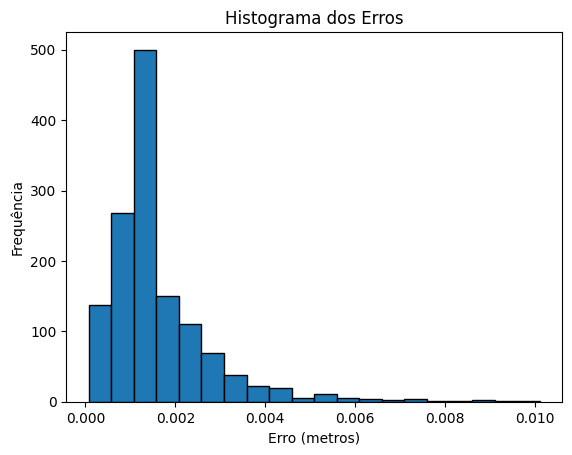

In [19]:
# Histograma e Box-Plot dos Erros
errors = np.sqrt(np.sum((y_pred - y_test) ** 2, axis=1))
plt.hist(errors, bins=20, edgecolor='k')
plt.xlabel('Erro (metros)')
plt.ylabel('Frequência')
plt.title('Histograma dos Erros')
plt.show()

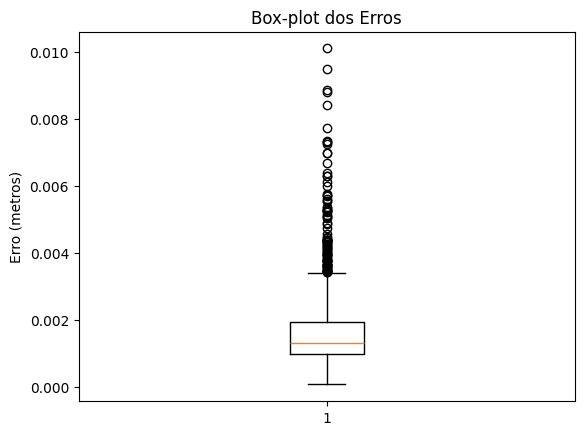

In [20]:
plt.boxplot(errors)
plt.ylabel('Erro (metros)')
plt.title('Box-plot dos Erros')
plt.show()